In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [21]:
# Read the data to a dataframe
src_df = pd.read_csv("binance-BTCUSDT-1m.csv")

# Make sure that the data is sorted by timestamp
src_df = src_df.sort_values("Timestamp")

# Create a mid price column
src_df["Mid"] = (src_df["High"] + src_df["Low"])/2

# Take 1/4 of the dataset for training and testing
df = src_df.iloc[int(len(df)*0.75):,:]

In [3]:
df.head()

,Timestamp,Open,High,Low,Close,N/A,Timestamp End,N/A.1,N/A.2,N/A.3,N/A.4,N/A.5,Time_UTC_Start,Mid
1500000,1621910040000,38444.05,38474.39,38405.96,38420.67,22.767546,1621910099999,8.752322e+05,920,10.475772,4.027407e+05,0,2021-05-25 02:34:00,38440.175
1500001,1621910100000,38420.67,38511.60,38420.67,38511.60,58.835952,1621910159999,2.263824e+06,1733,37.392164,1.439053e+06,0,2021-05-25 02:35:00,38466.135
1500002,1621910160000,38511.60,38633.88,38507.76,38576.55,88.386295,1621910219999,3.408770e+06,1969,42.908967,1.655350e+06,0,2021-05-25 02:36:00,38570.820
1500003,1621910220000,38576.65,38588.26,38524.15,38588.26,31.868284,1621910279999,1.228687e+06,1065,15.271695,5.888115e+05,0,2021-05-25 02:37:00,38556.205
1500004,1621910280000,38588.66,38588.66,38513.11,38513.11,48.218899,1621910339999,1.859370e+06,993,13.669738,5.271282e+05,0,2021-05-25 02:38:00,38550.885


In [4]:
num_rows, num_cols = df.shape

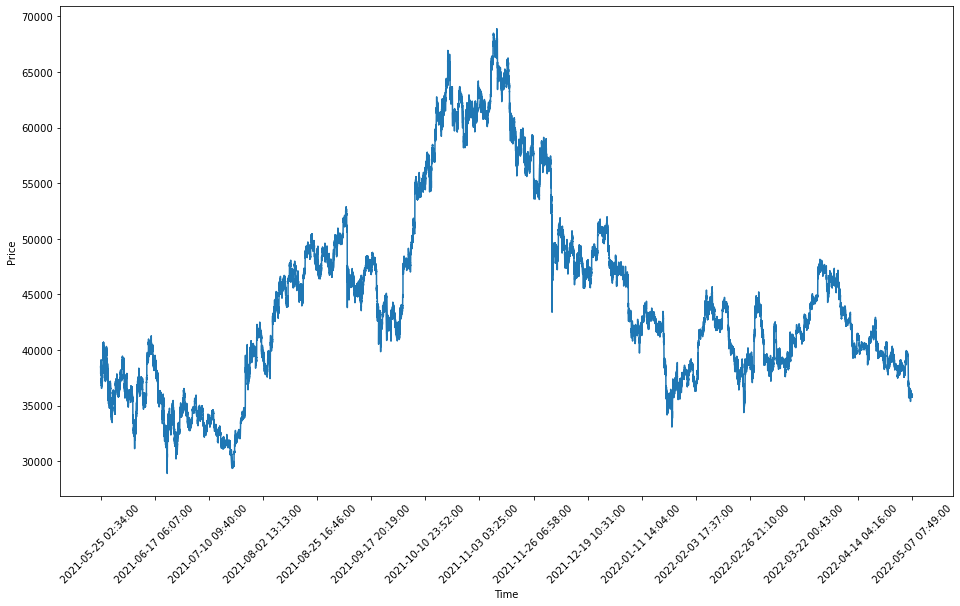

In [5]:
plt.figure(figsize = (16,9))
plt.plot(np.arange(0,df.shape[0]),(df["High"]+df["Low"])/2)
plt.xticks(np.arange(0,df.shape[0],len(df)//15), df["Time_UTC_Start"][::len(df)//15],rotation=45)
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [6]:
# Drop and add columns
df.index = df["Timestamp"]
df = df.drop(labels=["Time_UTC_Start", "Timestamp", "Timestamp End", "N/A.5"],axis=1)

# Save the index column of Mid
mid_col_idx = df.columns.get_loc("Mid")

In [7]:
train_data = df.iloc[0:int(len(df)*0.8),:].to_numpy()
num_rows_train, num_cols_train = train_data.shape
test_data = df.iloc[int(len(df)*0.8):].to_numpy()
num_rows_test, num_cols_test = test_data.shape

In [8]:
steps = 50

for i in range(0, num_rows_train, steps):
    scaler = MinMaxScaler().fit(train_data[i:i+steps])
    train_data[i:i+steps] = scaler.transform(train_data[i:i+steps])

In [9]:
scaler = MinMaxScaler().fit(test_data)
test_data = scaler.transform(test_data)

In [10]:
def split_sequences(data, window_size):
    x = []
    y = []
    for i in range(0,len(data)-window_size):
        x.append(data[i:i+window_size,:])
        y.append(data[i+window_size,mid_col_idx])
    return np.array(x), np.array(y)

In [11]:
x_train, y_train = split_sequences(train_data, steps)
x_test, y_test = split_sequences(test_data, steps)

In [12]:
print('Build model...')
model = Sequential()
model.add(LSTM(64, input_shape=(steps,x_train.shape[2])))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)
print('Train...')

model.fit(x_train, y_train, batch_size=128, epochs=2)

Build model...


2022-05-14 17:39:46.070969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 17:39:46.119904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-05-14 17:39:46.119918: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-14 17:39:46.120818: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

Train...
Epoch 1/2


2022-05-14 17:39:46.585363: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 799900000 exceeds 10% of free system memory.


3125/3125 [==============================] - 100s 32ms/step - loss: 0.0111
Epoch 2/2
3125/3125 [==============================] - 98s 31ms/step - loss: 0.0100


In [15]:
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

2022-05-14 17:45:15.822079: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 199900000 exceeds 10% of free system memory.


Score (RMSE): 0.01729613373227469


ValueError: The number of FixedLocator locations (16), usually from a call to set_ticks, does not match the number of ticklabels (76).

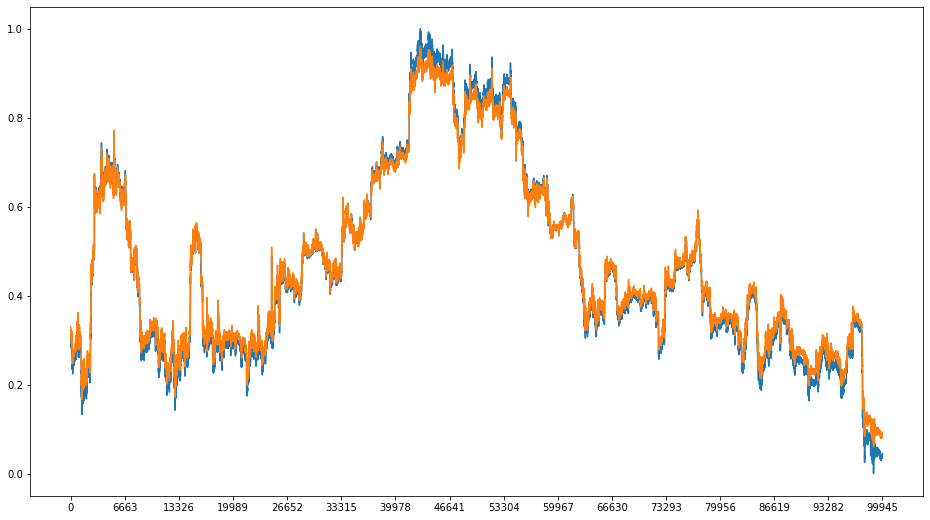

In [28]:
plt.figure(figsize = (16,9))
plt.plot(np.arange(0,y_test.shape[0]), y_test, label="Real")
plt.plot(np.arange(0,pred.shape[0]), pred, label="Prediction")
plt.xticks(np.arange(0,y_test.shape[0],y_test.shape[0]//15), src_df.iloc[int(len(src_df)*0.75):,:]["Time_UTC_Start"][::y_test.shape[0]//15],rotation=45)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [25]:
y_test.shape[0]

(99950,)

In [23]:
plt.figure(figsize = (16,9))
plt.plot(np.arange(0,y_test.shape[0]), y_test-pred, label="Difference")
plt.xticks(np.arange(0,y_test.shape[0],10000), df.iloc[int(len(df)*0.8):]["Time_UTC_Start"][::10000],rotation=45)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

MemoryError: Unable to allocate 74.4 GiB for an array with shape (99950, 99950) and data type float64

<Figure size 1152x648 with 0 Axes>